# ДЗ 2 Пропуски

## Загрузим датасет

In [1]:
import dill
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

In [2]:
OUTPUT_PATH = "../artifacts/cian_dataset_enriched.dill"

In [3]:
with open(OUTPUT_PATH, "rb") as f:
    try:
        df = dill.load(f)
    except Exception as e:
        print(f"Ошибка загрузки существующих данных: {e}")

In [4]:
df.head()

,object_title,object_subtitle,jk_name,deadline,geo,price,meter_price,desc,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,geo_7,rooms,sq_meters,floor,total_floors
0,"2-комн. квартира, 86,1 м², 4/13 этаж",Секция 1 • Сдача корпуса 3 кв. 2027,ЖК «Клубный город-парк «Фрунзенская набережная»,сдача ГК: 3 кв. 2027 года,"Москва, ЦАО, р-н Хамовники, м. Фрунзенская, Фр...",233470000,2711614,"Уютная квартира с двумя спальными комнатами, п...",Москва,ЦАО,р-н Хамовники,м. Фрунзенская,Фрунзенская набережная,30,None,None,2.0,86.1,4.0,13.0
1,"2-комн. апартаменты, 104,2 м², 5/9 этаж",Секция 1 • Сдан,ЖК «Vesper Tverskaya»,дом сдан,"Москва, ЦАО, р-н Тверской, м. Маяковская, 1-я ...",174388599,1673595,Продаются апартаменты с сервисом 5* отеля на 5...,Москва,ЦАО,р-н Тверской,м. Маяковская,1-я Тверская-Ямская улица,2А,None,None,2.0,104.2,5.0,9.0
2,"2-комн. апартаменты, 173,3 м², 1/6 этаж",Секция Подъезд 1 • Сдача корпуса 3 кв. 2027,ЖК «Клубный дом Левенсон»,сдача ГК: 3 кв. 2027 года,"Москва, ЦАО, р-н Пресненский, м. Пушкинская, П...",467910000,2700000,"Продаются апартаменты общей площадью 173,3 кв....",Москва,ЦАО,р-н Пресненский,м. Пушкинская,Патриаршие Пруды мкр,None,None,None,2.0,173.3,1.0,6.0
3,Студия. Выдача ключей!,"Студия, 26,57 м², 5/20 этаж",ЖК «FORST»,сдача ГК: 1 кв. 2025 года,"Москва, ЮАО, р-н Даниловский, м. Тульская, Фор...",13405991,504554,Выдача ключей! Квартира с отделкой White Box M...,Москва,ЮАО,р-н Даниловский,м. Тульская,Форст ЖК,None,None,None,NaN,NaN,NaN,NaN
4,"2-комн. квартира, 59,6 м², 15/49 этаж",Секция 1 • Сдача корпуса 2 кв. 2027,ЖК «TATE »,No_content,"Москва, СВАО, р-н Марьина роща, м. Марьина Рощ...",25411342,426365,Продается 2-комнатная квартира от застройщика ...,Москва,СВАО,р-н Марьина роща,м. Марьина Роща,Тэйт ЖК,None,None,None,2.0,59.6,15.0,49.0


### Перед началом работы исправим ошибки ДЗ 1

In [5]:
def extract_rooms(title):
    if pd.isna(title):
        return np.nan
    match = re.search(r'(\d+)-комн', title)
    return int(match.group(1)) if match else np.nan

def extract_sq_meters(title):
    if pd.isna(title):
        return np.nan
    match = re.search(r'(\d+[,.]\d+|\d+)\s*м²', title)
    if match:
        return float(match.group(1).replace(',', '.'))
    return np.nan

def extract_floors(title):
    if pd.isna(title):
        return np.nan, np.nan
    match = re.search(r'(\d+)/(\d+)\s*этаж', title)
    if match:
        return int(match.group(1)), int(match.group(2))
    return np.nan, np.nan

df['floor'], df['total_floors'] = zip(*df['object_subtitle'].apply(extract_floors))
df['rooms'] = df['object_subtitle'].apply(extract_rooms)
df['sq_meters'] = df['object_subtitle'].apply(extract_sq_meters)

## ДЗ 2 Пропуски

### Часть 1: «Следствие ведёт детектив»

Мы хорошо помним, что у нас существуют не только "честные" NaN, но и конструкция "No_content", являющаяся артефактом скраппинга. Давайте начнём с того, что сделаем честные пропуски везде

In [6]:
missing_values = ["No_content"]
df = df.replace(missing_values, np.nan)

In [7]:
df.isna().sum()

object_title          0
object_subtitle     495
jk_name              11
deadline            203
geo                  84
price                78
meter_price           0
desc                  0
geo_0                84
geo_1                84
geo_2                84
geo_3                88
geo_4               251
geo_5               800
geo_6              1640
geo_7              1740
rooms              1566
sq_meters          1538
floor              1538
total_floors       1538
dtype: int64

#### Видим сразу несколько проблем.
1. Забыли удалить метку geo
2. geo_5/6/7 составляют пропуски более чем 50% датасета.
3. Аномальное количество пропусков в колонках обогащения - наш регэксп не справился с задачей.

Сформулируем следующие гипотезы о пропусках:

1. object_subtitle - Особенности заполнения объявления.
2. jk_name - вторичка
3. deadline - унесено в subtitle или вторичка (попробуем выцепить из subtitle)
4. geo - нет точного адреса. Вот пример описания такого объекта (можно попробовать спарсить геометки, но это уже суровое NLP):
   
   'Уютная квартира с двумя спальными комнатами, панорамными окнами и балконами.\n\n"Фрунзенская набережная" - неповторимый элитный клубный город-парк в престижном и желанном месте на Фрунзенской набережной, где нет и не появится новых домов такого класса. Он находится в глубине парка площадью 3,1 гектара, где царит атмосфера загородной тишины и безмятежности.\n\nКлубный город-парк формируют три элегантных архитектурных стиля: неоклассика, современный стиль и авангард. Они воплощены в домах высотой от 5 до 13 этажей и роскошных двухэтажных виллах. Из панорамных окон открываются захватывающие виды на Кремль, Москву-реку, парк Горького и Нескучный сад. На масштабной территории только для своих создана богатейшая в своём классе насыщенная инфраструктура общей площадью 2700 кв. м. В отдельном здании находится Clubhouse - беспрецедентный инфраструктурный центр только для жителей c безграничными возможностями для общения, спорта и детского развития. В нём расположены: клубная гостиная для знакомства и общения людей своего круга; богатейшая инфраструктура для детей - игровой центр и бассейн; фитнес с 25-метровым бассейном и зоной спа.\n\nВо дворе-парке есть детские игровые площадки (600 кв. м), уникальная для элитного класса площадка для командных видов спорта (360 кв. м), пространство для йоги и медитации, воркаут-зона (100 кв. м).\n\nВ городе-парке более 150 вариантов квартир с особыми атрибутами: частными бассейнами, патио, видовыми террасами, дровяными каминами, потолками высотой до 7 метров.\n\nЖить на Фрунзенской набережной всегда считалось престижным и комфортным. Здесь много зелени, а монументальная набережная открывает безграничные возможности для прогулок.\n\nВ 100 метрах находится Москва-река, за которой раскинулись парк Горького, Нескучный сад и Воробьёвы горы - всего 219 гектаров природных пространств.'
5. geo4-7, прочие параметры адреса. Можнор опустить в силу разнородности, оставив только метро (geo3)
6. Последние 4 колонки - несовершенство функции, которая выделяет комнаты, метраж, этажи. Можно попробовать соптимизировать функцию. Метраж заполним расчётным образом цена/цену за метр

In [8]:
df

,object_title,object_subtitle,jk_name,deadline,geo,price,meter_price,desc,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,geo_7,rooms,sq_meters,floor,total_floors
0,"2-комн. квартира, 86,1 м², 4/13 этаж",Секция 1 • Сдача корпуса 3 кв. 2027,ЖК «Клубный город-парк «Фрунзенская набережная»,сдача ГК: 3 кв. 2027 года,"Москва, ЦАО, р-н Хамовники, м. Фрунзенская, Фр...",233470000,2711614,"Уютная квартира с двумя спальными комнатами, п...",Москва,ЦАО,р-н Хамовники,м. Фрунзенская,Фрунзенская набережная,30,None,None,NaN,NaN,NaN,NaN
1,"2-комн. апартаменты, 104,2 м², 5/9 этаж",Секция 1 • Сдан,ЖК «Vesper Tverskaya»,дом сдан,"Москва, ЦАО, р-н Тверской, м. Маяковская, 1-я ...",174388599,1673595,Продаются апартаменты с сервисом 5* отеля на 5...,Москва,ЦАО,р-н Тверской,м. Маяковская,1-я Тверская-Ямская улица,2А,None,None,NaN,NaN,NaN,NaN
2,"2-комн. апартаменты, 173,3 м², 1/6 этаж",Секция Подъезд 1 • Сдача корпуса 3 кв. 2027,ЖК «Клубный дом Левенсон»,сдача ГК: 3 кв. 2027 года,"Москва, ЦАО, р-н Пресненский, м. Пушкинская, П...",467910000,2700000,"Продаются апартаменты общей площадью 173,3 кв....",Москва,ЦАО,р-н Пресненский,м. Пушкинская,Патриаршие Пруды мкр,None,None,None,NaN,NaN,NaN,NaN
3,Студия. Выдача ключей!,"Студия, 26,57 м², 5/20 этаж",ЖК «FORST»,сдача ГК: 1 кв. 2025 года,"Москва, ЮАО, р-н Даниловский, м. Тульская, Фор...",13405991,504554,Выдача ключей! Квартира с отделкой White Box M...,Москва,ЮАО,р-н Даниловский,м. Тульская,Форст ЖК,None,None,None,NaN,26.57,5.0,20.0
4,"2-комн. квартира, 59,6 м², 15/49 этаж",Секция 1 • Сдача корпуса 2 кв. 2027,ЖК «TATE »,NaN,"Москва, СВАО, р-н Марьина роща, м. Марьина Рощ...",25411342,426365,Продается 2-комнатная квартира от застройщика ...,Москва,СВАО,р-н Марьина роща,м. Марьина Роща,Тэйт ЖК,None,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156,"1-комн. квартира, 49,5 м², 11/17 этаж",NaN,ЖК «Зеленый Остров»,NaN,"Московская область, Котельники, м. Котельники,...",6650000,134343,Продается просторная Однокомнатная квартира на...,Московская область,Котельники,м. Котельники,Южный мкр,8,None,None,None,NaN,NaN,NaN,NaN
3158,"1-комн. квартира, 38,5 м², 5/17 этаж",NaN,NaN,NaN,"Московская область, Люберцы, мкр. Городок Б, м...",8000000,207792,"Ставка на ипотеку от 14,99% \nСкидки на страхо...",Московская область,Люберцы,мкр. Городок Б,м. Жулебино,улица 3-е Почтовое Отделение,55,None,None,NaN,NaN,NaN,NaN
3159,"1-комн. квартира, 35,6 м², 9/10 этаж",NaN,NaN,NaN,"Московская область, Реутов, мкр. Северный Реут...",7700000,216292,Данная сделка застрахована САО РЕСО-гарантия!\...,Московская область,Реутов,мкр. Северный Реутов,м. Реутов,Ашхабадская улица,25,None,None,NaN,NaN,NaN,NaN
3160,Лучшее предложение на районе!,"2-комн. квартира, 43,4 м², 5/5 этаж",NaN,NaN,"Московская область, Балашиха, мкр. Балашиха-1,...",5380000,123963,Скидка на ипотечную ставку до 10 % !\nДанная с...,Московская область,Балашиха,мкр. Балашиха-1,м. Салтыковская,улица Мира,13,None,None,2.0,43.40,5.0,5.0


### Выбросы
Наличие выбросов очень характерно для ценовых значений и они легко визуализируются в ДЗ 1. Мы применим два метода работы с выбросами:
1. Простой - обрезка по цене.
2. Сложный - isolationForest. Этот метод будет применён без детального погружения в технологию как некоторый "чёрный ящик", хорошо зарекомендовавший себя на подобных задачах в моём опыте ранее.

### Часть 2: «Выбор подходящего оружия»
Шмалять будем со всех орудий.

1. object_subtitle и jk_name - заполним dummy филлером.
2. deadline - попытаемся вычленить из subtitle, иначе заполним числовым филлером
3. Пустой geo - филлер + филлер для всех значений geo1-7
4. geo4-7 - удалить столбцы, не забыть в конце удалить geo
5. rooms/floors/total_floors - подкрутим функции-парсеры
6. sqare_meters - рассчитаем.
7. price - при наличии метража - заполним рассчётно, иначе - удалим объект.

Стратегия работы с выбросами описана выше.

Преобразования, описанные при работе с пропусками, не должны дать значимого смещения распределений. Тем не менее, работа с выбросами точно распределение сдвинет, и это надо будет замерить.

In [9]:
FILLER = "dummy"

In [10]:
# 1. object_subtitle и jk_name - заполним dummy филлером.
df['object_subtitle'] = df['object_subtitle'].fillna(FILLER)
df['jk_name'] = df['jk_name'].fillna(FILLER)

In [11]:
# 2. deadline - попытаемся вычленить из subtitle, иначе заполним числовым филлером


def extract_quarter_year(text):
    """Извлекает квартал и год из текста с помощью регулярного выражения"""
    if pd.isna(text):
        return None, None
    
    # Ищем паттерны типа "X кв. YYYY" или "кв. YYYY"
    match = re.search(r'(\d+)\s*кв\.\s*(\d{4})', str(text))
    if match:
        return match.group(1), match.group(2)
    return None, None

# Применяем функцию к обоим столбцам
df[['deadline_q', 'deadline_y']] = df['deadline'].apply(
    lambda x: pd.Series(extract_quarter_year(x))
)

df[['subtitle_q', 'subtitle_y']] = df['object_subtitle'].apply(
    lambda x: pd.Series(extract_quarter_year(x))
)

# Объединяем результаты с приоритетом deadline
df['quarter'] = df['deadline_q'].combine_first(df['subtitle_q'])
df['year'] = df['deadline_y'].combine_first(df['subtitle_y'])

# Удаляем временные столбцы
df = df.drop(['deadline_q', 'deadline_y', 'subtitle_q', 'subtitle_y'], axis=1)

# Конвертируем типы данных (если нужно)
df['quarter'] = pd.to_numeric(df['quarter'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

df = df.drop(columns=['deadline'])

# 438 пустых записей. Рискнём заполнить квартал - средним, а год - максимальным
mean_quarter = round(df['quarter'].mean())
max_year = df['year'].max() 
df['quarter'] = df['quarter'].fillna(mean_quarter)
df['year'] = df['year'].fillna(max_year)

df['quarter'] = df['quarter'].astype(int)
df['year'] = df['year'].astype(int)

In [12]:
# 3. Пустой geo - филлер + филлер для всех значений geo1-7
df.loc[df['geo'].isna(), ['geo', 'geo_0', 'geo_1', 'geo_2', 'geo_3']] = FILLER

In [13]:
#4. geo4-7 - удалить столбцы, не забыть в конце удалить geo
df = df.drop(columns=['geo', 'geo_4', 'geo_5', 'geo_6', 'geo_7'])

In [14]:
#5. rooms/floors/total_floors - подкрутим функции-парсеры

def extract_rooms(text):
    if pd.isna(text):
        return np.nan
    
    text = text.lower()  # Приводим к нижнему регистру для унификации
    
    # Сначала проверяем студии
    studio_pattern = r'\b(апартаменты-)?студи(я|и|й|ю|ей|ям?|ями|ях)\b'
    if re.search(studio_pattern, text):
        return 0.5
    
    # Затем проверяем обычные комнаты
    match = re.search(r'(\d+)[-]?(?:комн|к| комнат?)\.?', text)
    return int(match.group(1)) if match else np.nan

def extract_sq_meters(title):
    if pd.isna(title):
        return np.nan
    # Ищем числа с разделителями . или , перед "м²" или "м2"
    match = re.search(r'(\d+[.,]?\d*)\s*(?:м²|м2|м\^2)', title)
    if match:
        value = match.group(1).replace(',', '.')
        return float(value)
    return np.nan

def extract_floors(title):
    if pd.isna(title):
        return (np.nan, np.nan)
    # Ищем паттерны этажей: "X/Y этаж", "X из Y этаж"
    match = re.search(r'(\d+)\s*[/из]+\s*(\d+)\s*этаж', title)
    return (int(match.group(1)), int(match.group(2))) if match else (np.nan, np.nan)


# Сначала пробуем извлечь из object_subtitle
df[['floor_sub', 'total_floors_sub']] = pd.DataFrame(
    df['object_subtitle'].apply(extract_floors).tolist(),
    index=df.index
)
df['rooms_sub'] = df['object_subtitle'].apply(extract_rooms)
df['sq_meters_sub'] = df['object_subtitle'].apply(extract_sq_meters)

# Затем из object_title
df[['floor_title', 'total_floors_title']] = pd.DataFrame(
    df['object_title'].apply(extract_floors).tolist(),
    index=df.index
)
df['rooms_title'] = df['object_title'].apply(extract_rooms)
df['sq_meters_title'] = df['object_title'].apply(extract_sq_meters)

# Объединяем с приоритетом subtitle
df['floor'] = df['floor_sub'].combine_first(df['floor_title'])
df['total_floors'] = df['total_floors_sub'].combine_first(df['total_floors_title'])
df['rooms'] = df['rooms_sub'].combine_first(df['rooms_title'])
df['sq_meters'] = df['sq_meters_sub'].combine_first(df['sq_meters_title'])

# Удаляем временные колонки
df.drop(columns=[
    'floor_sub', 'total_floors_sub', 'rooms_sub', 'sq_meters_sub',
    'floor_title', 'total_floors_title', 'rooms_title', 'sq_meters_title'
], inplace=True)

In [15]:
df.isna().sum()

object_title        0
object_subtitle     0
jk_name             0
price              78
meter_price         0
desc                0
geo_0               0
geo_1               0
geo_2               0
geo_3               4
rooms               5
sq_meters           0
floor               0
total_floors        0
quarter             0
year                0
dtype: int64

In [16]:
# План меняется, у нас почти не осталось пропусков. Заполним свободные планировки как 0
df.loc[df['rooms'].isna(), ['rooms']] = 0

In [17]:
# Теперь посмотрим экстремальные значения метро. Там нет метро. Поставим филлер.
df.loc[df['geo_3'].isna(), ['geo_3']] = FILLER

In [18]:
#7. price - при наличии метража - заполним рассчётно, иначе - удалим объект. У нас всегда есть метраж.
df['price'] = df.apply(
    lambda row: (row['meter_price'] * row['sq_meters']) 
    if pd.isna(row['price']) 
    else row['price'], 
    axis=1
)
df["price"] = df["price"].astype("int64")

In [19]:
df.isna().sum()

object_title       0
object_subtitle    0
jk_name            0
price              0
meter_price        0
desc               0
geo_0              0
geo_1              0
geo_2              0
geo_3              0
rooms              0
sq_meters          0
floor              0
total_floors       0
quarter            0
year               0
dtype: int64

Прекрасный, девственно-чистый датасет без пропусков. Глянем категориальные

In [20]:
cat_columns = df.select_dtypes(include=['object']).columns
df.describe(include=['object'])

,object_title,object_subtitle,jk_name,desc,geo_0,geo_1,geo_2,geo_3
count,1742,1742,1742,1742,1742,1742,1742,1742
unique,1559,322,309,1525,3,73,165,253
top,Студия. Выдача ключей!,dummy,ЖК «Новое Пушкино»,ЖК Новоград Монино - квартиры с ключами от 4.6...,Московская область,ЦАО,Ленинский городской округ,м. Медведково
freq,9,495,44,35,1077,128,197,128


Предположим, что нам не нужны больше колонки object_title и object_subtitle - всю информацию от них мы получили. jk_name, geo1-3 закодируем с помощью LabelEncoder (чтобы легко вернуться к оригинальным лейблам), geo0 - OHE, desc предполагает обработку с помощью NLP. Сделаем базовую предобработку - эмбеддер и PCA на макс объяснимой дисперсии 90%.

In [21]:
le_jk = LabelEncoder()
le_g1 = LabelEncoder()
le_g2 = LabelEncoder()
le_g3 = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False, drop="first")

df["jk_name"] = le_jk.fit_transform(df["jk_name"])
df["geo_1"] = le_g1.fit_transform(df["geo_1"])
df["geo_2"] = le_g2.fit_transform(df["geo_2"])
df["geo_3"] = le_g3.fit_transform(df["geo_3"])

geo = ohe.fit_transform(df[['geo_0']])
geo_names = ohe.get_feature_names_out(['geo_0'])

f_geo = pd.DataFrame(geo, columns=geo_names)

df = pd.concat([df.reset_index(drop=True), f_geo.reset_index(drop=True)], axis=1)

df = df.drop(columns=['object_title', 'object_subtitle', 'geo_0'])

In [22]:
# теперь - NLP
def get_embeddings(texts, model_name='cointegrated/rubert-tiny2'):
    model = SentenceTransformer(model_name)
    return model.encode(texts, show_progress_bar=True)

text_embeddings = get_embeddings(df['desc'].tolist())

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(text_embeddings)

pca = PCA(n_components=0.9, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

for i in range(reduced_embeddings.shape[1]):
    df[f'text_pca_{i+1}'] = reduced_embeddings[:, i]

df = df.drop(columns=['desc'])

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

In [23]:
df.head()

,jk_name,price,meter_price,geo_1,geo_2,geo_3,rooms,sq_meters,floor,total_floors,...,text_pca_63,text_pca_64,text_pca_65,text_pca_66,text_pca_67,text_pca_68,text_pca_69,text_pca_70,text_pca_71,text_pca_72
0,172,233470000,2711614,36,152,209,2.0,86.10,4.0,13.0,...,1.576588,1.219949,0.266247,0.810172,-0.707129,0.456254,-0.681933,-0.145420,1.829463,0.918564
1,89,174388599,1673595,36,148,136,2.0,104.20,5.0,9.0,...,-1.532706,0.224146,-1.141701,0.377237,1.875367,-0.902752,0.645713,-0.716871,0.843934,-0.301882
2,177,467910000,2700000,36,137,178,2.0,173.30,1.0,6.0,...,-0.170844,0.175011,0.086890,0.265295,-0.476918,-0.626868,0.842697,1.110654,-0.895777,-0.269965
3,26,13405991,504554,38,104,202,0.5,26.57,5.0,20.0,...,1.583061,1.436902,-0.005236,1.061296,0.614086,0.312192,0.272495,0.224747,-0.139308,-0.610298
4,83,25411342,426365,31,120,135,2.0,59.60,15.0,49.0,...,1.103964,-0.720227,-0.153473,1.313323,-0.989415,0.234416,0.082311,0.465104,0.874877,-0.121432


Отличный ненормализованный датасет. Глянем распределения

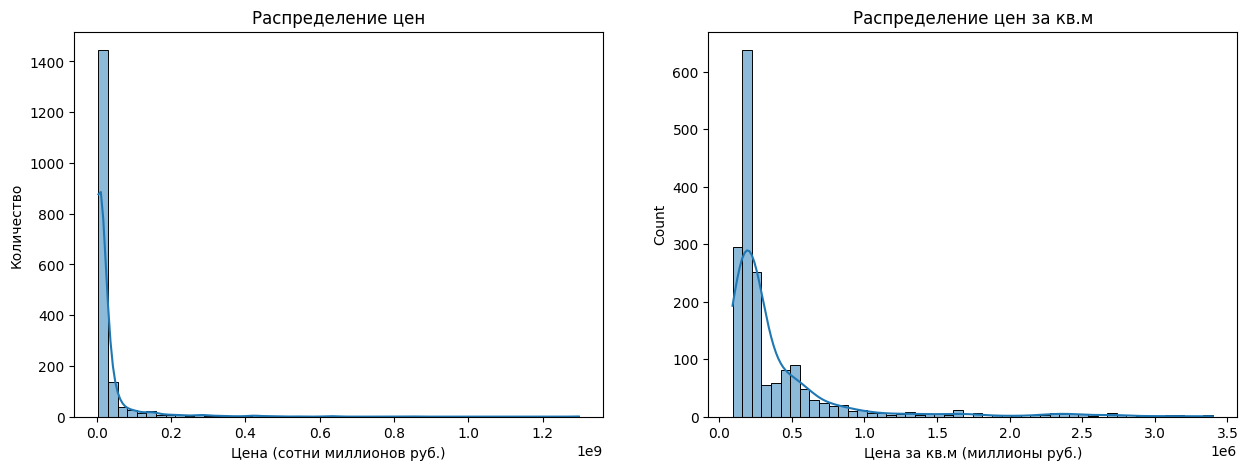

In [24]:
# Построение распределений
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Распределение цен')
plt.xlabel('Цена (сотни миллионов руб.)')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
sns.histplot(df['meter_price'], bins=50, kde=True)
plt.title('Распределение цен за кв.м')
plt.xlabel('Цена за кв.м (миллионы руб.)')
plt.show()

In [25]:
df.describe()

,jk_name,price,meter_price,geo_1,geo_2,geo_3,rooms,sq_meters,floor,total_floors,...,text_pca_63,text_pca_64,text_pca_65,text_pca_66,text_pca_67,text_pca_68,text_pca_69,text_pca_70,text_pca_71,text_pca_72
count,1742.000000,1.742000e+03,1.742000e+03,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,...,1.742000e+03,1.742000e+03,1.742000e+03,1.742000e+03,1.742000e+03,1.742000e+03,1.742000e+03,1.742000e+03,1.742000e+03,1.742000e+03
mean,165.836969,2.682382e+07,3.889188e+05,34.863949,67.488519,129.556257,1.185132,43.513289,7.640643,17.555109,...,5.693578e-08,4.708151e-08,9.580540e-09,2.217211e-08,-2.189838e-08,4.817643e-08,-6.569513e-09,-8.184519e-08,1.450768e-08,-3.448994e-08
std,80.490747,7.070417e+07,4.642996e+05,19.778683,54.829920,74.335038,0.868276,31.240645,7.301855,11.549365,...,9.625031e-01,9.542618e-01,9.443388e-01,9.371026e-01,9.293637e-01,9.121993e-01,8.986582e-01,8.878492e-01,8.830497e-01,8.658282e-01
min,0.000000,4.000000e+06,9.095000e+04,0.000000,0.000000,0.000000,0.000000,12.300000,1.000000,3.000000,...,-3.375067e+00,-4.959576e+00,-4.050142e+00,-3.416671e+00,-3.440409e+00,-1.014272e+01,-4.406281e+00,-3.922853e+00,-4.670457e+00,-4.424138e+00
25%,112.000000,5.320414e+06,1.697655e+05,19.000000,11.000000,69.000000,0.500000,25.820000,2.000000,9.000000,...,-6.054316e-01,-5.727378e-01,-6.030566e-01,-5.220035e-01,-5.473108e-01,-4.665153e-01,-4.478836e-01,-5.367153e-01,-5.447934e-01,-4.292812e-01
50%,167.000000,6.005661e+06,2.141805e+05,36.000000,61.000000,137.000000,1.000000,34.015000,5.000000,17.000000,...,-2.976614e-02,4.764461e-02,4.007477e-02,-2.127620e-02,7.068663e-02,-1.005601e-02,3.186454e-02,4.425435e-02,-2.640833e-02,1.853505e-02
75%,232.000000,1.968359e+07,4.285752e+05,48.000000,117.000000,200.000000,1.000000,44.400000,11.000000,22.000000,...,5.659403e-01,5.109173e-01,5.509849e-01,5.383674e-01,5.680297e-01,5.151339e-01,5.310884e-01,5.144821e-01,4.833018e-01,4.615332e-01
max,308.000000,1.297600e+09,3.400000e+06,72.000000,164.000000,252.000000,5.000000,405.500000,67.000000,85.000000,...,4.121340e+00,4.037594e+00,3.649384e+00,3.806041e+00,3.787235e+00,3.953290e+00,4.073662e+00,3.335957e+00,4.110331e+00,4.257267e+00


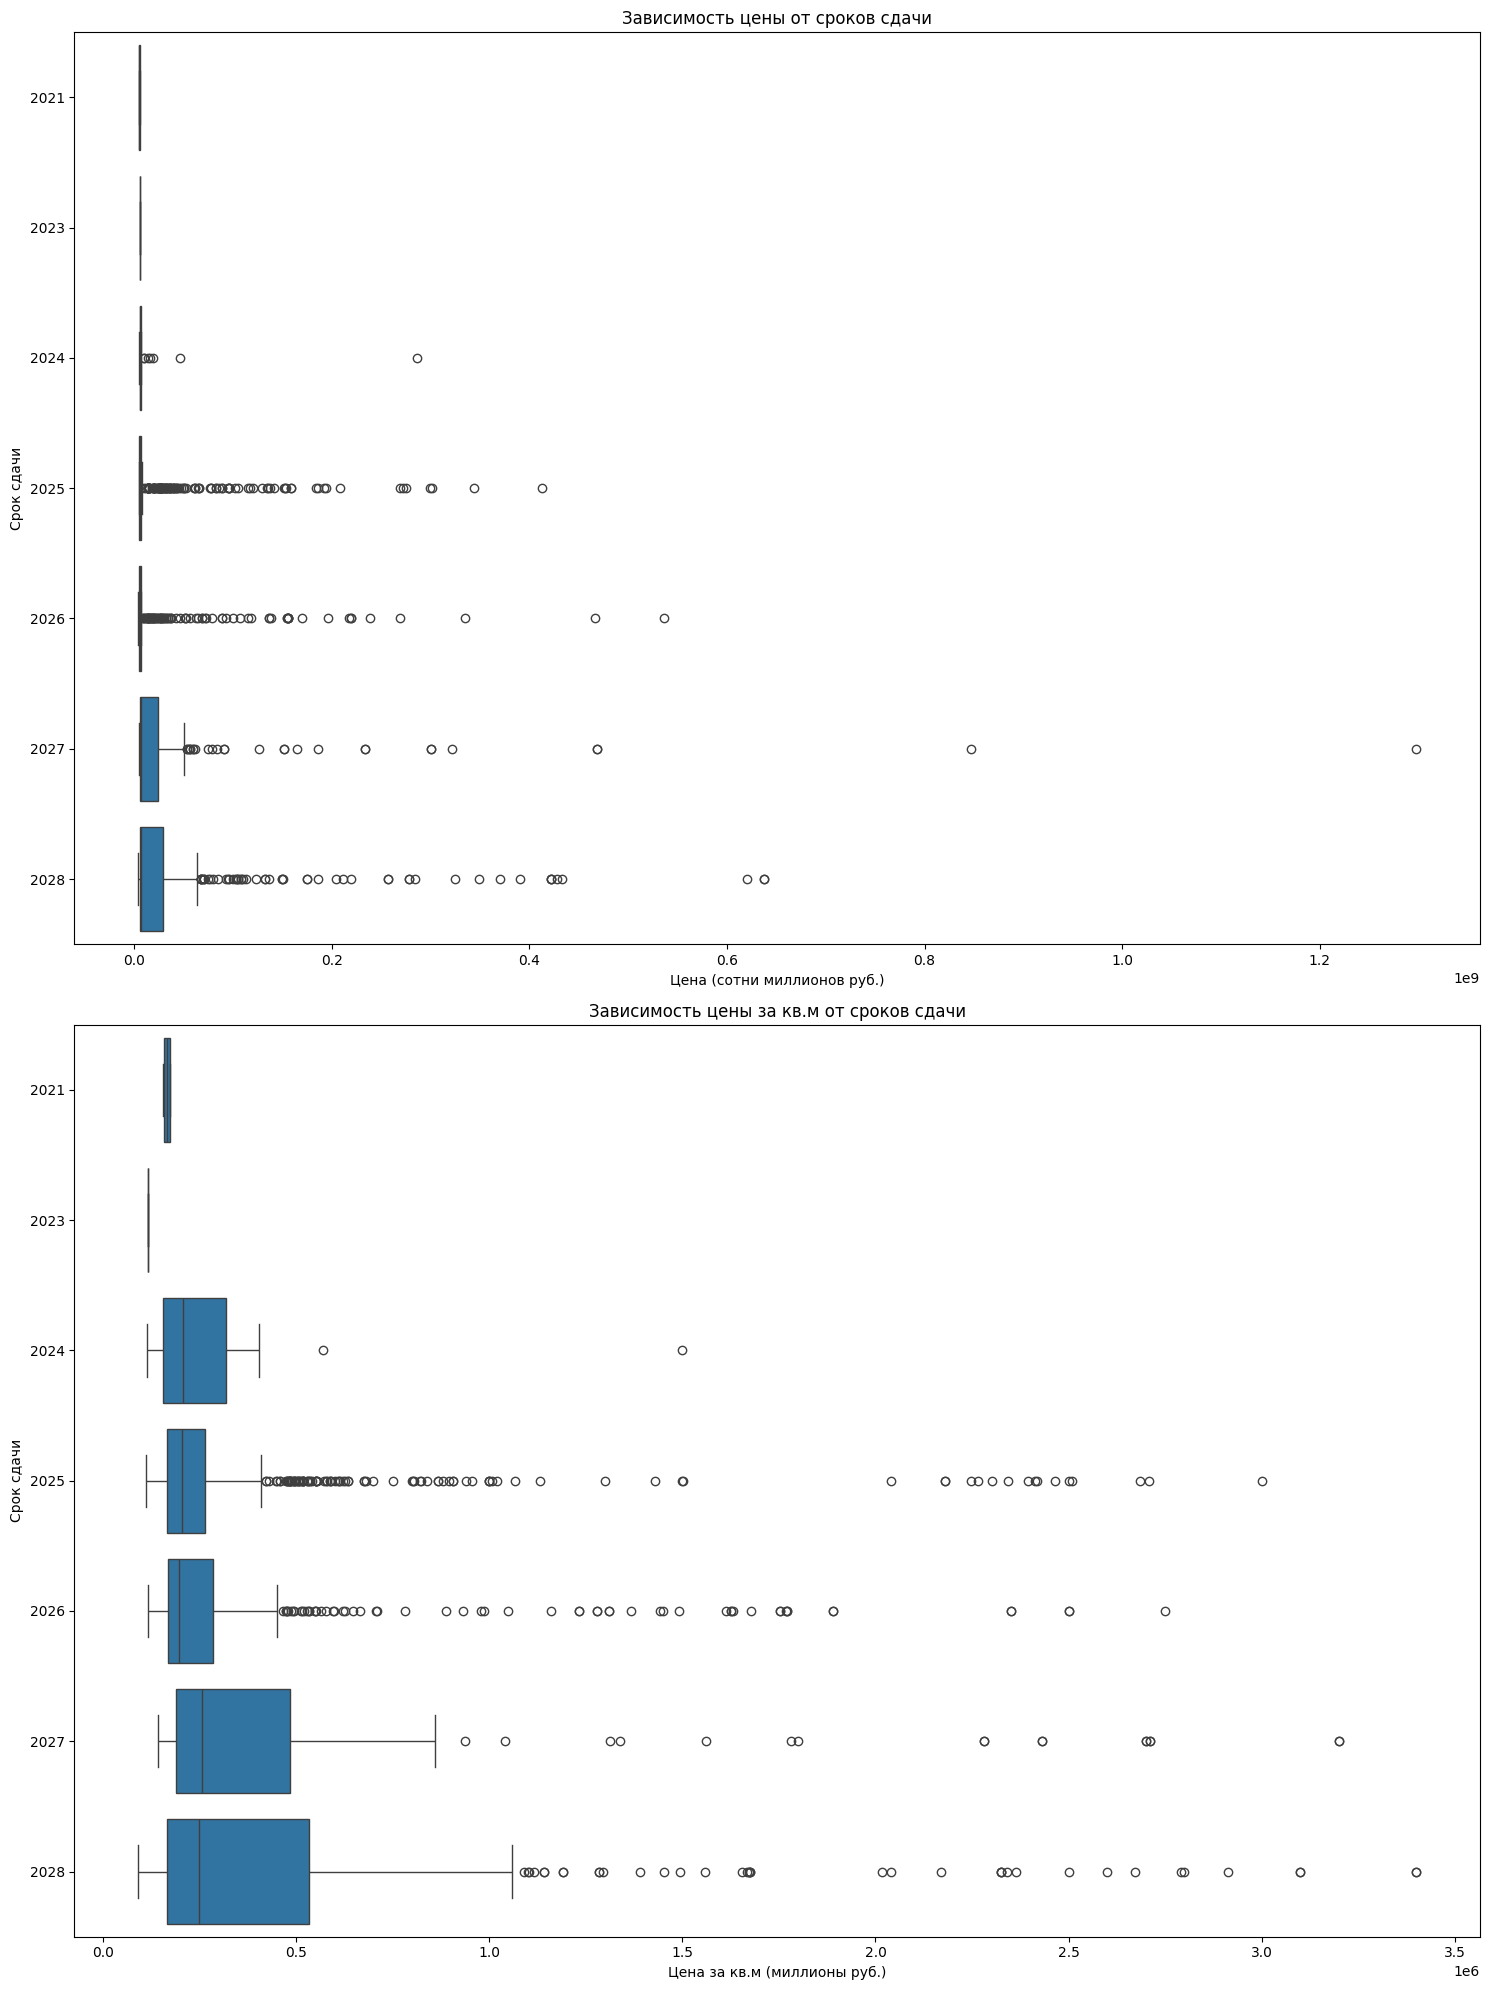

In [26]:
data_vis = df.copy()
data_vis['year'] = data_vis['year'].astype('category')
# График для средней цены
plt.figure(figsize=(15, 20))

plt.subplot(2, 1, 1)
sns.boxplot(data=data_vis, x='price', y='year')
plt.title('Зависимость цены от сроков сдачи')
plt.xlabel('Цена (сотни миллионов руб.)')
plt.ylabel('Срок сдачи')

plt.subplot(2, 1, 2)
sns.boxplot(data=data_vis, x='meter_price', y='year')
plt.title('Зависимость цены за кв.м от сроков сдачи')
plt.xlabel('Цена за кв.м (миллионы руб.)')
plt.ylabel('Срок сдачи')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Станция метро')

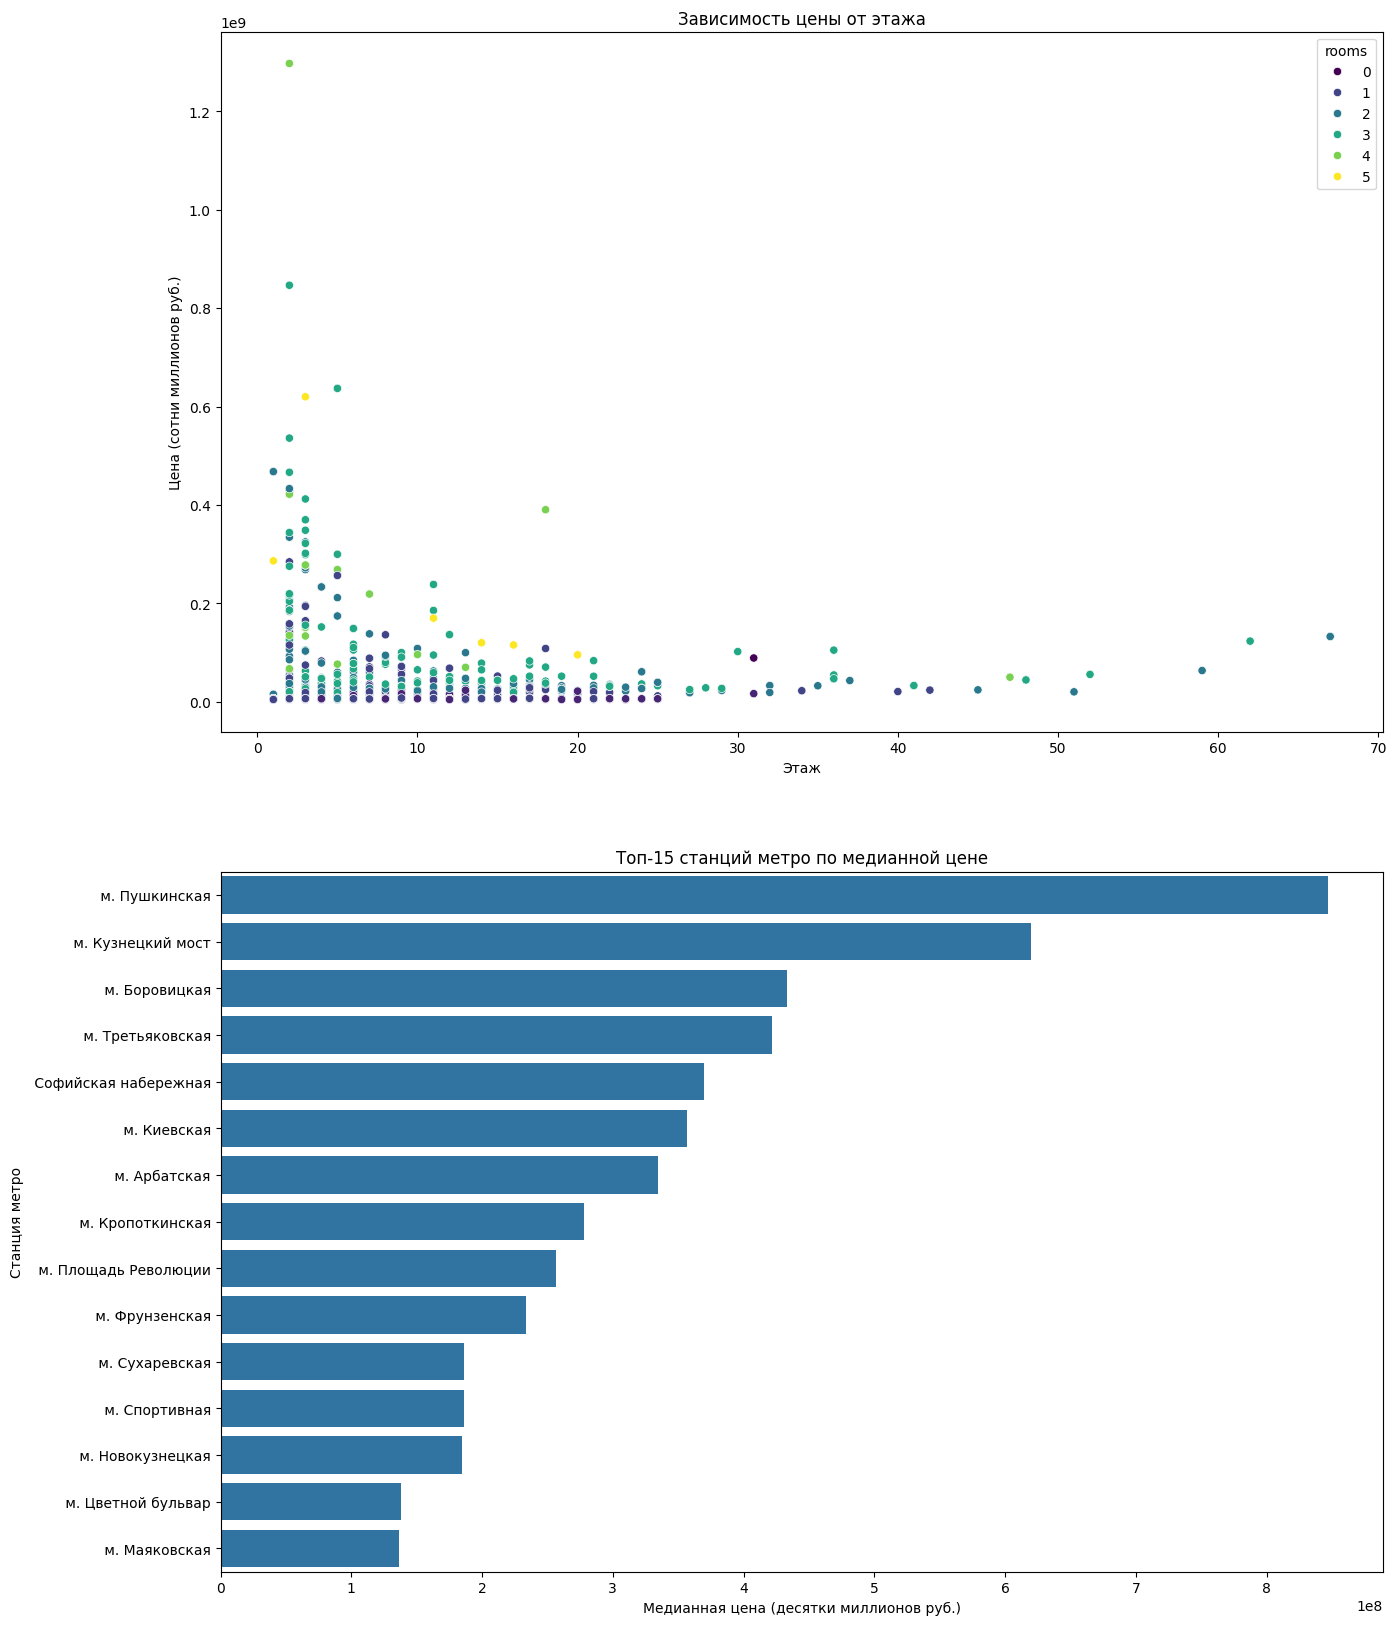

In [27]:
# 7. Визуализация зависимостей этаж/цена, метро/цена
plt.figure(figsize=(15, 20))

# Зависимость этаж/цена
plt.subplot(2, 1, 1)
sns.scatterplot(data=df, x='floor', y='price', hue='rooms', palette='viridis')
plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена (сотни миллионов руб.)')

# Зависимость метро/цена (используем 4-е значение из geo)
plt.subplot(2, 1, 2)
df_copy = df.copy()
df_copy['geo_3'] = le_g3.inverse_transform(df_copy['geo_3'])
metro_prices = df_copy.groupby('geo_3')['price'].median().sort_values(ascending=False).head(15)
sns.barplot(x=metro_prices.values, y=metro_prices.index)
plt.title('Топ-15 станций метро по медианной цене')
plt.xlabel('Медианная цена (десятки миллионов руб.)')
plt.ylabel('Станция метро')

In [28]:
# Теперь у нас нет категориальных признаков и мы можем подготовиться к замеру смещения распределений для анализа выбросов.
num_columns = df.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df_scaled= df.copy()
df_scaled[num_columns] = scaler.fit_transform(df[num_columns])


X = df_scaled.drop(columns=['price', 'meter_price'])
y = df_scaled['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_preds = reg.predict(X_test)
print(mean_squared_error(y_test, y_preds))
print(np.sqrt(mean_squared_error(y_test, y_preds)))

0.271273098981934
0.5208388416601953


Визуально распределения не тронуты, как мы и предполагали. Поработаем с выбросами!
Примем цену 1.2млн за кв.метр (прости нас, Собянин) как выброс.

In [29]:
df_cleaned = df[df['meter_price'] < 1.2e+6]
df_cleaned.shape

(1648, 86)

In [30]:
# Уехало примерно 100 записей. Неплохой результат. Теперь, тяжёлая артиллерия. IsolationForest.

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05, # На автоматическом режиме уезжает ущё примерно 300 записей. Поставим 5%
    random_state=42
)

outliers = iso_forest.fit_predict(df_cleaned[num_columns])

df_cleaned  = df_cleaned[outliers == 1]
df_cleaned.shape

(1565, 86)

In [31]:
# И вот теперь время замерить распределения

df_cleaned.describe()

,jk_name,price,meter_price,geo_1,geo_2,geo_3,rooms,sq_meters,floor,total_floors,...,text_pca_63,text_pca_64,text_pca_65,text_pca_66,text_pca_67,text_pca_68,text_pca_69,text_pca_70,text_pca_71,text_pca_72
count,1565.000000,1.565000e+03,1.565000e+03,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,...,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000
mean,169.003195,1.295718e+07,2.843203e+05,34.800639,61.846645,126.852396,1.090735,38.185821,7.665176,17.728435,...,0.011369,-0.029731,-0.004103,-0.018648,0.008870,0.002042,-0.009510,-0.002072,-0.018701,0.003780
std,79.977742,1.736869e+07,1.876779e+05,20.026578,52.899311,75.144383,0.784935,20.861562,7.016903,11.212935,...,0.889414,0.857075,0.911388,0.878102,0.889432,0.813570,0.841068,0.855553,0.841602,0.813946
min,0.000000,4.000000e+06,9.095000e+04,0.000000,0.000000,0.000000,0.000000,12.300000,1.000000,3.000000,...,-2.685781,-3.102732,-4.050142,-3.416671,-3.378799,-3.696889,-3.168274,-3.157415,-3.144053,-2.852144
25%,112.000000,5.270000e+06,1.677170e+05,19.000000,9.000000,58.000000,0.500000,25.360000,2.000000,10.000000,...,-0.564193,-0.574177,-0.601374,-0.500431,-0.511136,-0.451493,-0.427676,-0.508450,-0.529668,-0.401092
50%,170.000000,5.911128e+06,2.050000e+05,35.000000,50.000000,133.000000,1.000000,32.900000,6.000000,17.000000,...,-0.014008,0.047645,0.035159,-0.037427,0.090997,-0.007843,0.031779,0.048636,-0.033987,0.024130
75%,232.000000,1.020000e+07,3.072300e+05,48.000000,104.000000,201.000000,1.000000,40.790000,11.000000,22.000000,...,0.553328,0.458351,0.527307,0.500454,0.564093,0.513153,0.500475,0.497959,0.448338,0.459835
max,308.000000,1.514200e+08,1.190993e+06,72.000000,164.000000,252.000000,5.000000,184.080000,62.000000,85.000000,...,3.283733,2.893831,3.649384,3.806041,3.260827,3.274610,3.218837,2.822738,3.196136,3.027196


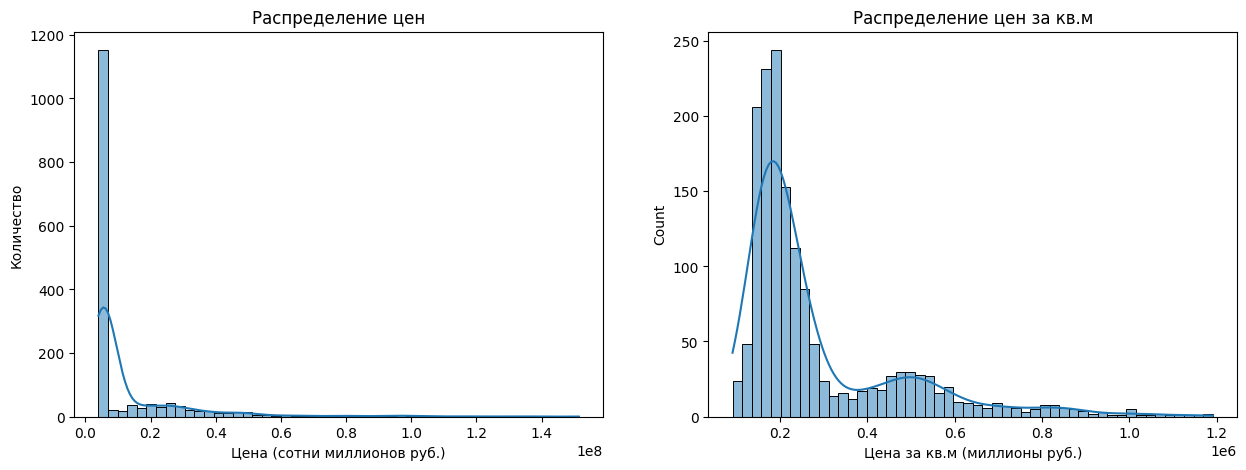

In [32]:
# Построение распределений
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['price'], bins=50, kde=True)
plt.title('Распределение цен')
plt.xlabel('Цена (сотни миллионов руб.)')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['meter_price'], bins=50, kde=True)
plt.title('Распределение цен за кв.м')
plt.xlabel('Цена за кв.м (миллионы руб.)')
plt.show()

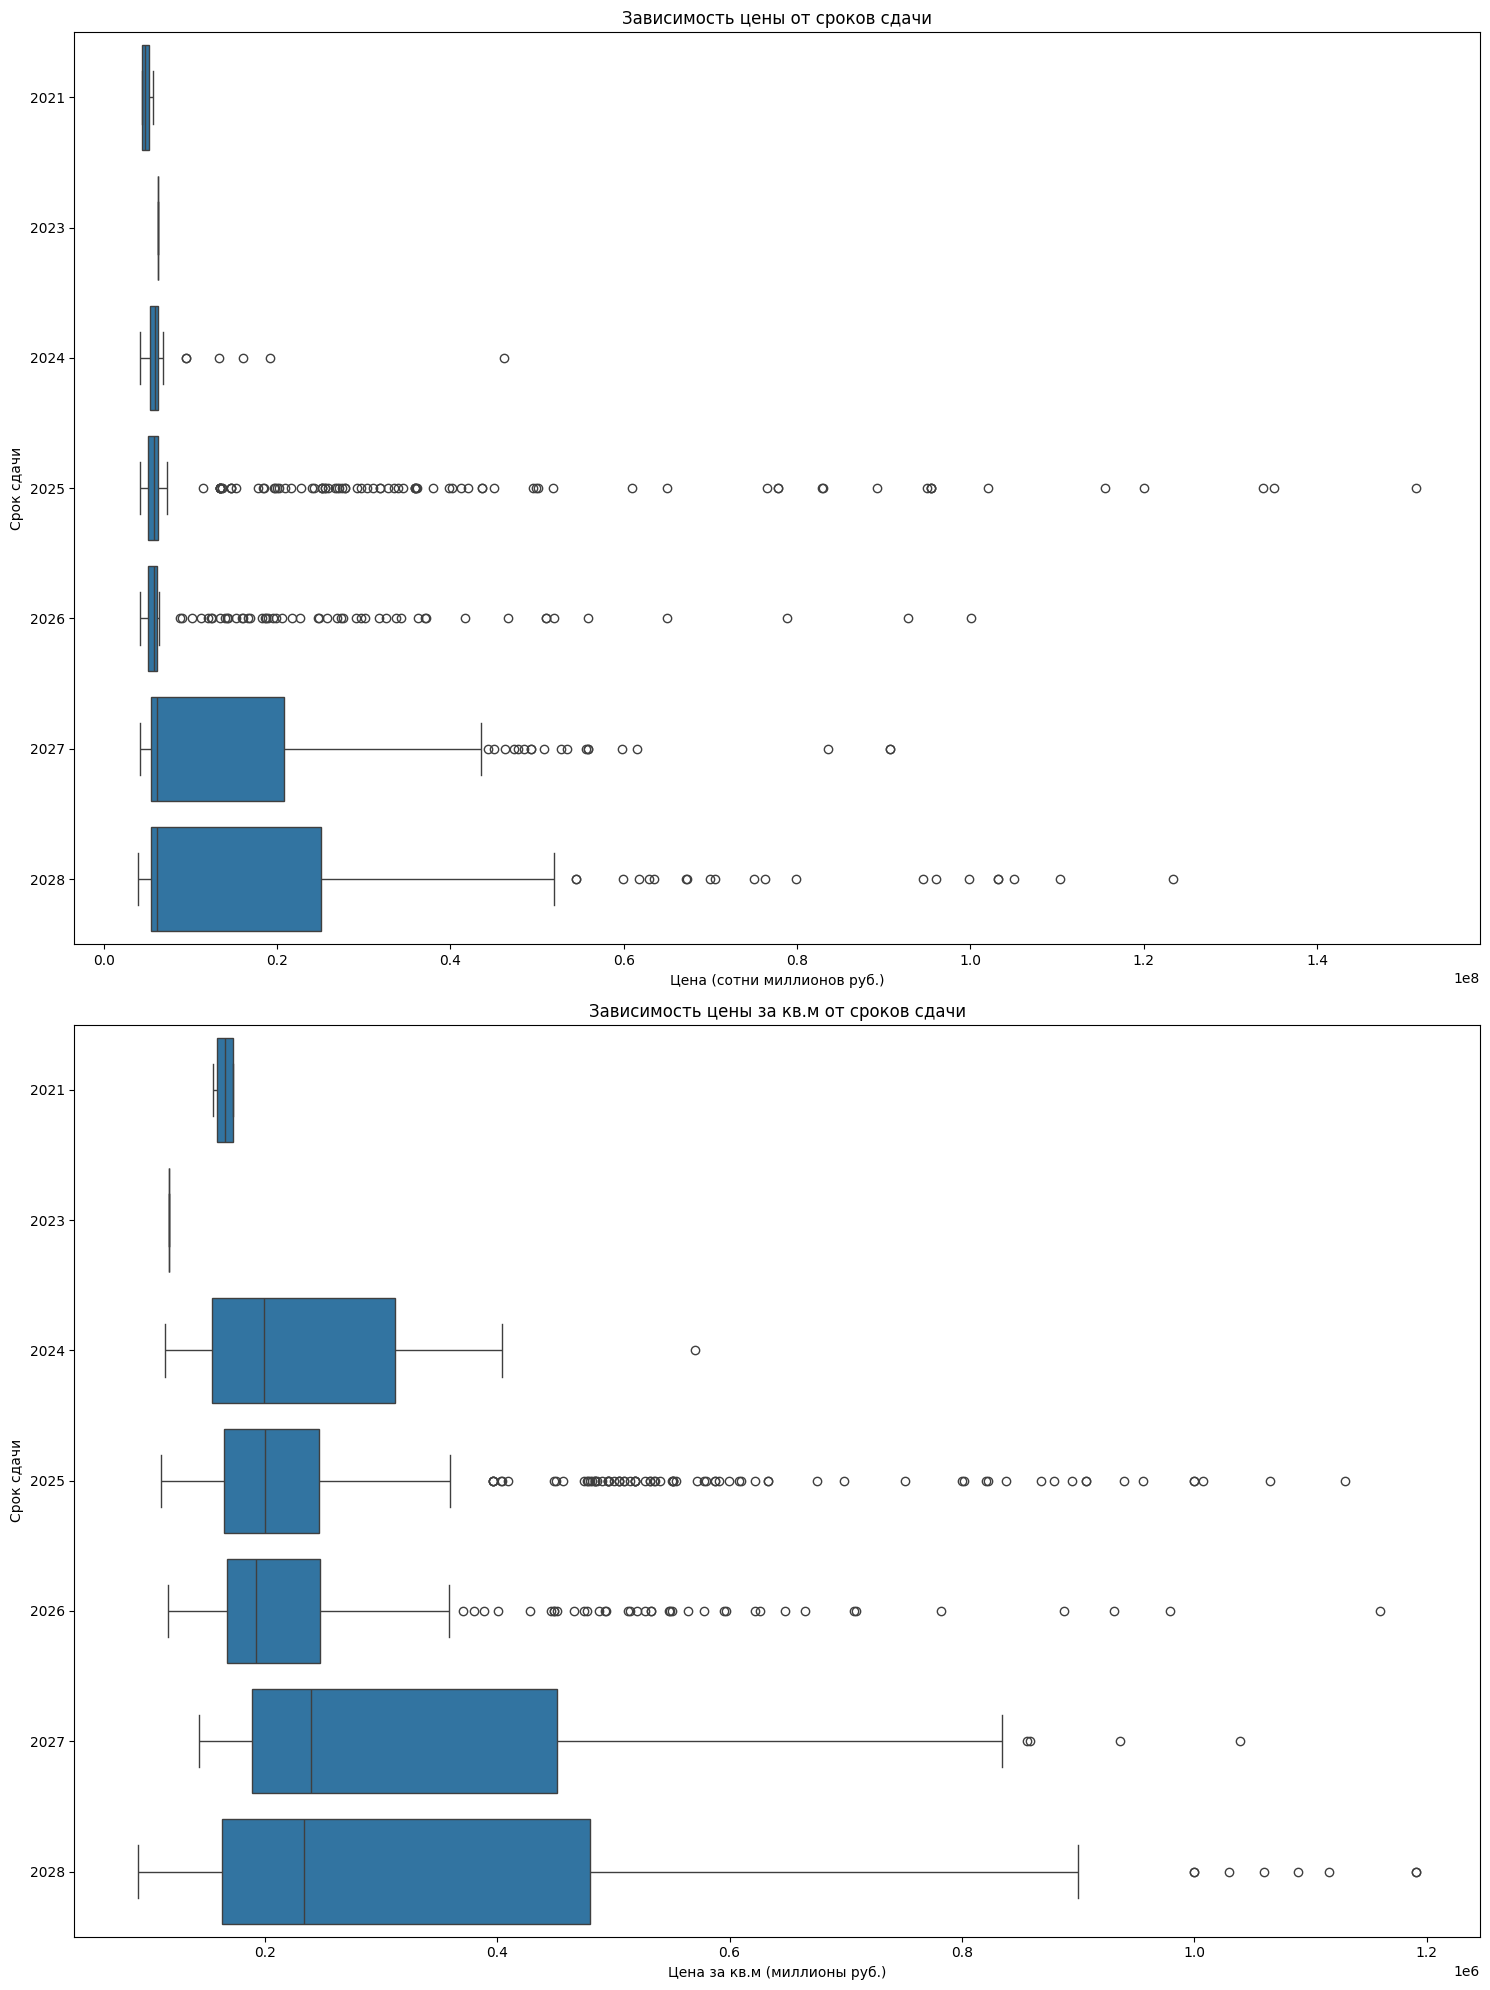

In [33]:
data_vis = df_cleaned.copy()
data_vis['year'] = data_vis['year'].astype('category')
# График для средней цены
plt.figure(figsize=(15, 20))

plt.subplot(2, 1, 1)
sns.boxplot(data=data_vis, x='price', y='year')
plt.title('Зависимость цены от сроков сдачи')
plt.xlabel('Цена (сотни миллионов руб.)')
plt.ylabel('Срок сдачи')

plt.subplot(2, 1, 2)
sns.boxplot(data=data_vis, x='meter_price', y='year')
plt.title('Зависимость цены за кв.м от сроков сдачи')
plt.xlabel('Цена за кв.м (миллионы руб.)')
plt.ylabel('Срок сдачи')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Станция метро')

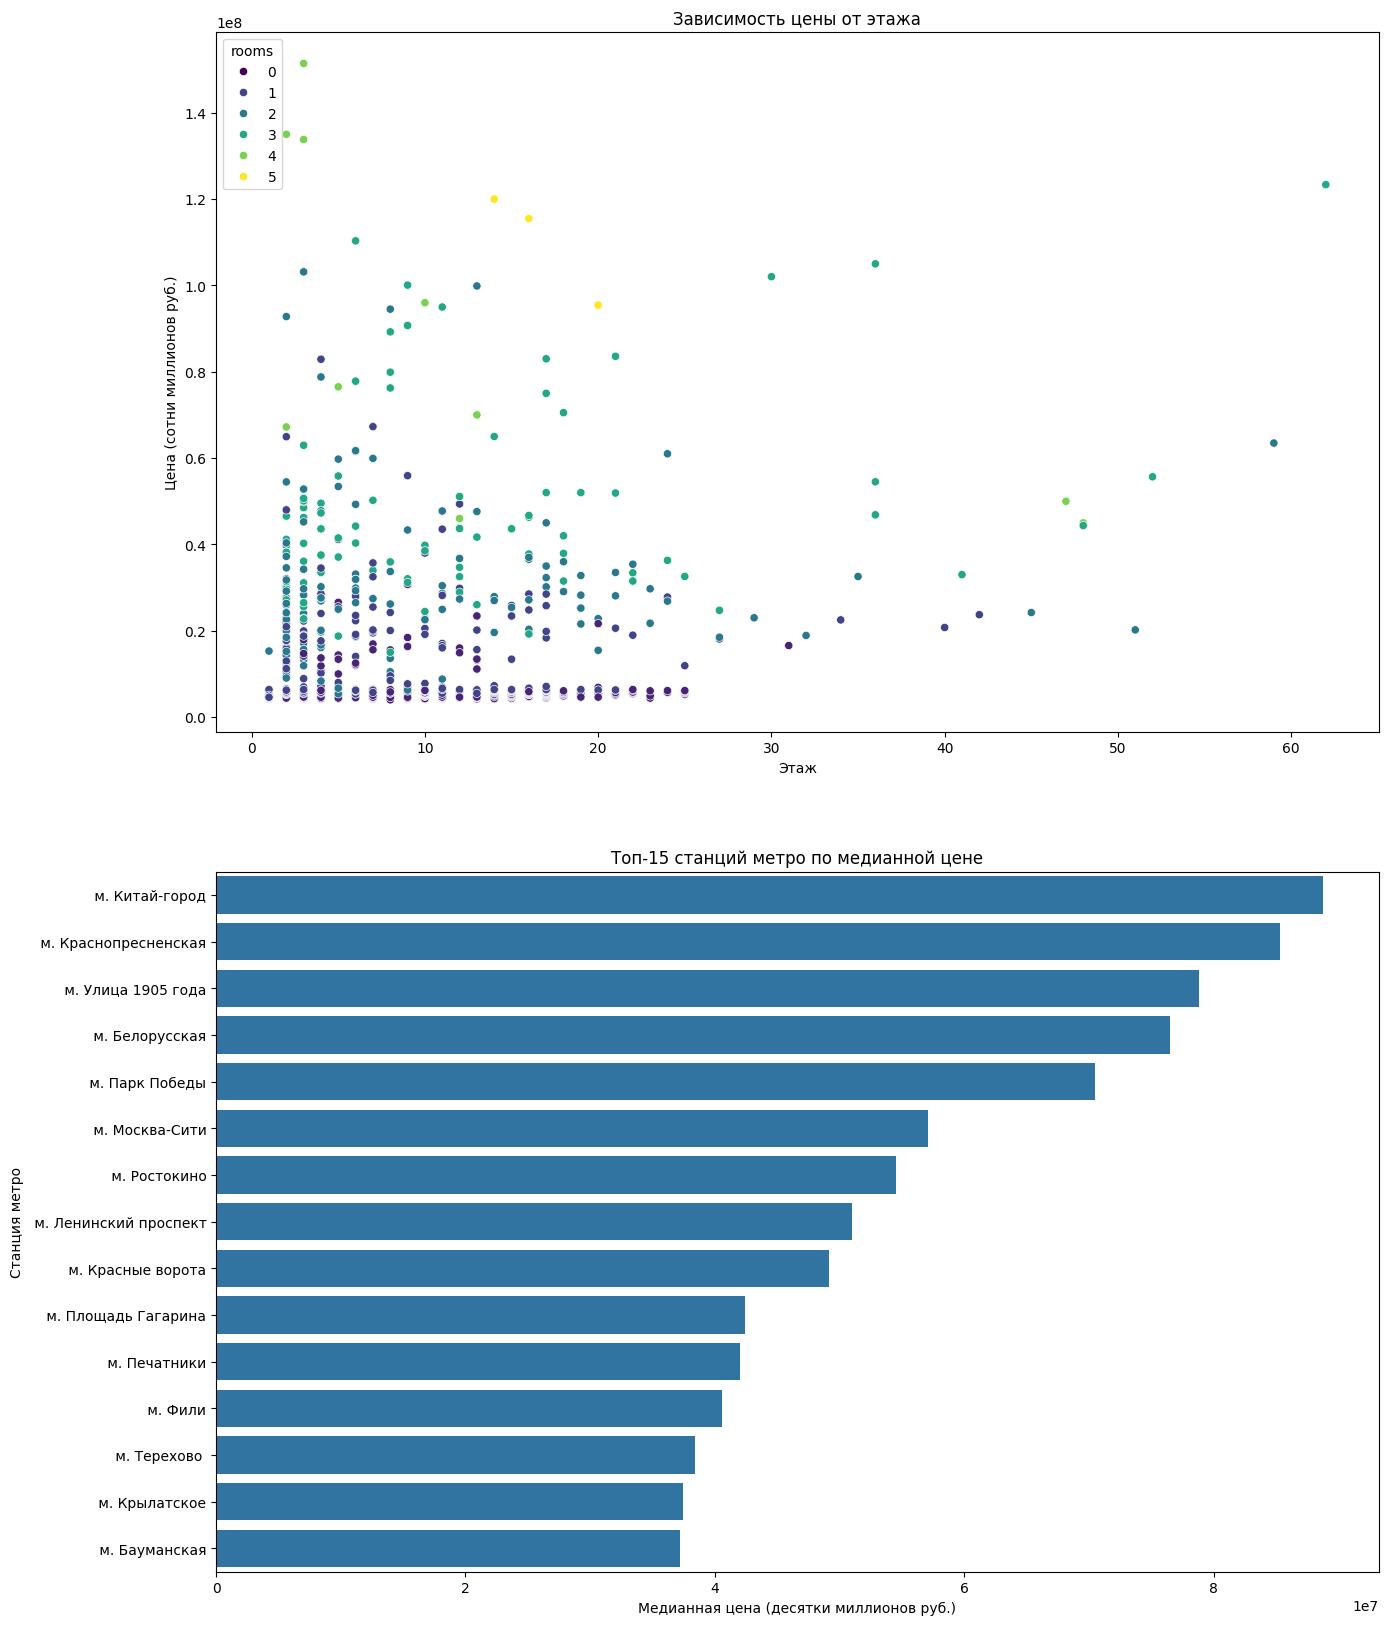

In [34]:
# 7. Визуализация зависимостей этаж/цена, метро/цена
plt.figure(figsize=(15, 20))

# Зависимость этаж/цена
plt.subplot(2, 1, 1)
sns.scatterplot(data=df_cleaned, x='floor', y='price', hue='rooms', palette='viridis')
plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена (сотни миллионов руб.)')

# Зависимость метро/цена (используем 4-е значение из geo)
plt.subplot(2, 1, 2)
df_copy = df_cleaned.copy()
df_copy['geo_3'] = le_g3.inverse_transform(df_copy['geo_3'])
metro_prices = df_copy.groupby('geo_3')['price'].median().sort_values(ascending=False).head(15)
sns.barplot(x=metro_prices.values, y=metro_prices.index)
plt.title('Топ-15 станций метро по медианной цене')
plt.xlabel('Медианная цена (десятки миллионов руб.)')
plt.ylabel('Станция метро')

In [35]:
# Посмотрим, не поломалась ли регрессия

num_columns = df_cleaned.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df_scaled= df_cleaned.copy()
df_scaled[num_columns] = scaler.fit_transform(df_cleaned[num_columns])


X = df_scaled.drop(columns=['price', 'meter_price'])
y = df_scaled['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_preds = reg.predict(X_test)
print(mean_squared_error(y_test, y_preds))
print(np.sqrt(mean_squared_error(y_test, y_preds)))

0.15862897478481242
0.3982825313578445


In [36]:
df_iso = df.copy()

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05, # На автоматическом режиме уезжает ущё примерно 300 записей. Поставим 5%
    random_state=42
)

outliers = iso_forest.fit_predict(df_iso[num_columns])

df_iso  = df_iso[outliers == 1]
print(df_iso.shape)

scaler = StandardScaler()
df_scaled = df_iso.copy()
df_scaled[num_columns] = scaler.fit_transform(df_iso[num_columns])


X = df_scaled.drop(columns=['price', 'meter_price'])
y = df_scaled['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_preds = reg.predict(X_test)
print(mean_squared_error(y_test, y_preds))
print(np.sqrt(mean_squared_error(y_test, y_preds)))

(1654, 86)
0.30343333711503245
0.550847834810152


In [37]:
# Даже стала лучше. А давайте провернём тот же финт, но на чистом isolation_forest?
df_iso = df.copy()

iso_forest = IsolationForest(
    n_estimators=100,
    contamination='auto',
    random_state=42
)

outliers = iso_forest.fit_predict(df_iso)

df_iso  = df_iso[outliers == 1]
print(df_iso.shape)

scaler = StandardScaler()
df_scaled = df_iso.copy()
df_scaled[num_columns] = scaler.fit_transform(df_iso[num_columns])


X = df_scaled.drop(columns=['price', 'meter_price'])
y = df_scaled['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_preds = reg.predict(X_test)
print(mean_squared_error(y_test, y_preds))
print(np.sqrt(mean_squared_error(y_test, y_preds)))


(1700, 86)
0.15042372552710517
0.3878449761529794


## Часть 3: «Раскрытие дела»

Если заполнение пропусков значимо на распределения не повлияло, то избавление от выбросов по числовым признакам выкинуло целые станции метро из топа. Очевидно, что это некоторые сверхдорогие квартиры, которые закрывают очень небольшую часть первых объявлений ЦИАН и они не являются чем-то нормальным, однако, подобные методы очистки теряют ценный сегмент продаж - эксклюзив.

Мы экспериментально показали, что чистый isolationForest работает с выбросами на нашем датасете лучше, чем ценовая эвристика + isolationForest.

Наиболее эффективный метод заполнения пропусков оказался двухслойным парсингом заголовка + подзаголовка объявления, для заполнения этажа, комнат, метража, и, как следствие, цены. Это и есть уникальный метод заполнения пропусков для данного датасета.

Краткая рекомендация по обработке пропущенных значений:

1. object_subtitle и jk_name - заполним dummy филлером.
2. deadline - попытаемся вычленить из subtitle, иначе заполним средним и максимумом
3. Пустой geo - филлер + филлер для всех значений geo1-7
4. geo4-7 - удалить столбцы, не забыть в конце удалить geo
5. rooms/floors/total_floors/sqare_meters - подкрутим функции-парсеры
6. price - при наличии метража - заполним рассчётно, иначе - удалим объект.


In [38]:
OUTPUT_PATH = "../artifacts/cian_dataset_cleaned.dill"
with open(OUTPUT_PATH, "wb") as f:
    try:
        dill.dump(df_iso, f)
    except Exception as e:
        print(f"Ошибка загрузки существующих данных: {e}")